In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, cv2, pickle, json, itertools
import imgaug.augmenters as iaa
import imgaug.imgaug

from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.utils import class_weight
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from PIL import Image, ImageDraw
import json,sys,random

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *

In [ ]:
with open('/content/drive/MyDrive/archive (1)/shipsnet.json') as data_file:
    dataset = json.load(data_file)
shipsnet= pd.DataFrame(dataset)
shipsnet.head()

data  labels  \
0  [82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...       1   
1  [76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...       1   
2  [125, 127, 129, 130, 126, 125, 129, 133, 132, ...       1   
3  [102, 99, 113, 106, 96, 102, 105, 105, 103, 10...       1   
4  [78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...       1   

                                   locations             scene_ids  
0    [-118.2254694333423, 33.73803725920789]  20180708_180909_0f47  
1    [-122.33222866289329, 37.7491755586813]  20170705_180816_103e  
2  [-118.14283073363218, 33.736016066914175]  20180712_211331_0f06  
3   [-122.34784341495181, 37.76648707436548]  20170609_180756_103a  
4   [-122.34852408322172, 37.75878462398653]  20170515_180653_1007

In [ ]:
shipsnet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       4000 non-null   object
 1   labels     4000 non-null   int64 
 2   locations  4000 non-null   object
 3   scene_ids  4000 non-null   object
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


In [ ]:
shipsnet = shipsnet[["data", "labels"]]
shipsnet.head()

data  labels
0  [82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...       1
1  [76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...       1
2  [125, 127, 129, 130, 126, 125, 129, 133, 132, ...       1
3  [102, 99, 113, 106, 96, 102, 105, 105, 103, 10...       1
4  [78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...       1

In [ ]:
ship_images = shipsnet["labels"].value_counts()[0]
no_ship_images = shipsnet["labels"].value_counts()[1]
print("Number of the ship_images :{}".format(ship_images),"\n")
print("Number of the no ship_images :{}".format(no_ship_images))

Number of the ship_images :3000 

Number of the no ship_images :1000


In [ ]:
x = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')

In [ ]:
x.shape

(4000, 19200)

In [ ]:
x_reshaped = x.reshape([-1, 3, 80, 80])
x_reshaped.shape

(4000, 3, 80, 80)

In [ ]:
x_reshaped = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
x_reshaped.shape

(4000, 80, 80, 3)

In [ ]:
y.shape
y_reshaped = to_categorical(y, num_classes=2)

y_reshaped.shape

(4000, 2)

In [ ]:
y_reshaped

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
image_no_ship = x_reshaped[y==0]
image_ship = x_reshaped[y==1]

def plot(a,b):

    plt.figure(figsize=(15, 15))
    for i, k in enumerate(range(1,9)):
        if i < 4:
            plt.subplot(2,4,k)
            plt.title('Not A Ship')
            plt.imshow(image_no_ship[i+10])
            plt.axis("off")
        else:
            plt.subplot(2,4,k)
            plt.title('Ship')
            plt.imshow(image_ship[i+25])
            plt.axis("off")

    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0.25)


In [ ]:
def plotHistogram(ship, not_ship):

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(ship)
    plt.axis('off')
    plt.title('Ship')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(ship[:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(ship[:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(ship[:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()
    print("Minimum pixel value of this image: {}".format(ship.min()))
    print("Maximum pixel value of this image: {}".format(ship.max()))
    plt.figure(figsize = (10,7))
    plt.subplot(2,2,3)
    plt.imshow(not_ship)
    plt.axis('off')
    plt.title('Not A Ship')
    histo = plt.subplot(2,2,4)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(not_ship[:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(not_ship[:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(not_ship[:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()
    print("Minimum pixel value of this image: {}".format(not_ship.min()))
    print("Maximum pixel value of this image: {}".format(not_ship.max()))

In [ ]:
import plotly.express as px
import pandas as pd



label_counts = shipsnet['labels'].value_counts()



fig = px.bar(x=label_counts.index, y=label_counts.values,
             labels={'x': 'Label', 'y': 'Count'},
             title="Bar Graph of DataFrame's 'Label' Column")



fig.show()

label_counts = shipsnet['labels'].value_counts()
# Create the pie chart using Plotly Express
fig = px.pie(names=['Not A Ship', 'Ship'], values=label_counts.values,

             hole=0.3)  # Adjust the 'hole' parameter to add space between segments



# Show the plot
fig.show()

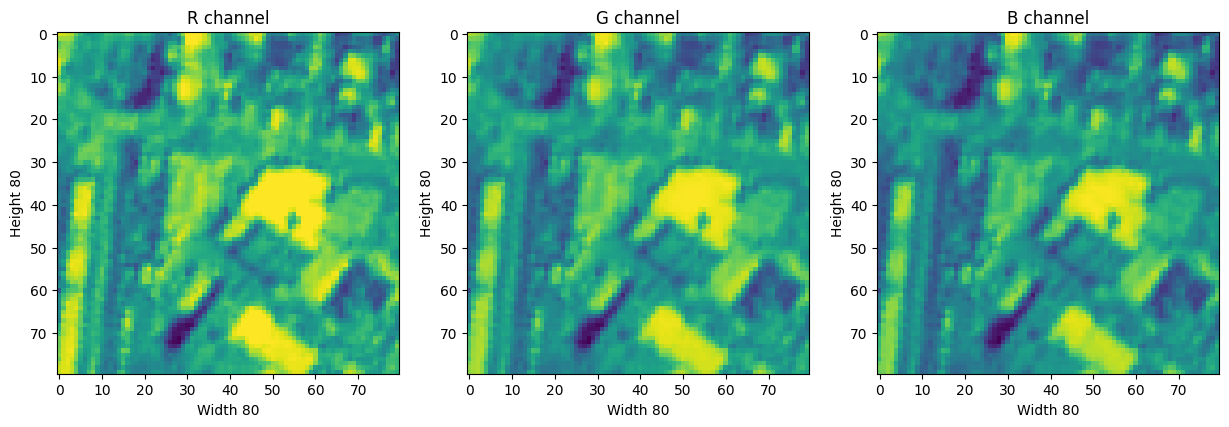

In [ ]:
my_list = [(0, 'R channel'), (1, 'G channel'), (2, 'B channel')]

plt.figure(figsize = (15,15))

for i, k in my_list:
    plt.subplot(1,3,i+1)
    plt.title(k)
    plt.ylabel('Height {}'.format(x_reshaped[y==0][5].shape[0]))
    plt.xlabel('Width {}'.format(x_reshaped[y==0][5].shape[1]))
    plt.imshow(x_reshaped[y==0][5][ : , : , i])

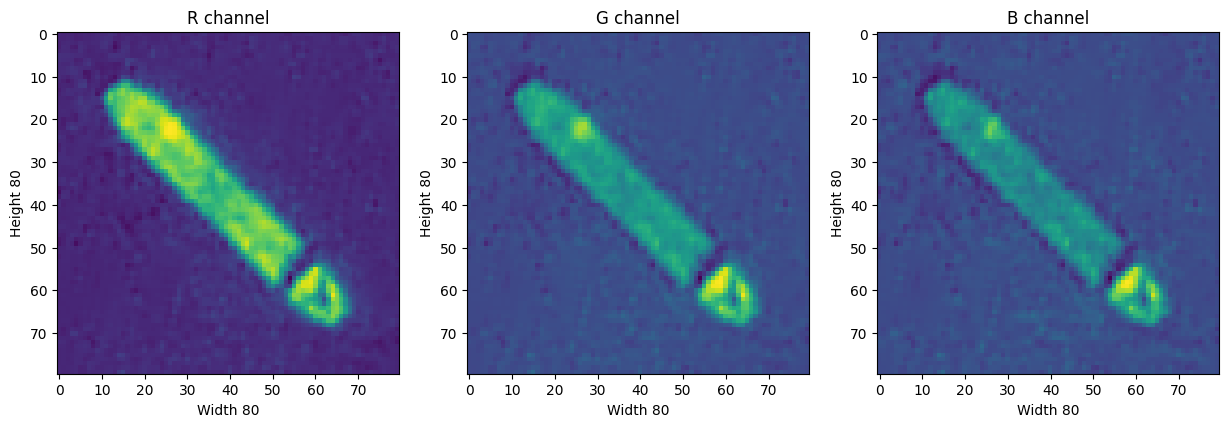

In [ ]:
my_list = [(0, 'R channel'), (1, 'G channel'), (2, 'B channel')]

plt.figure(figsize = (15,15))

for i, k in my_list:
    plt.subplot(1,3,i+1)
    plt.title(k)
    plt.ylabel('Height {}'.format(x_reshaped[y==0][5].shape[0]))
    plt.xlabel('Width {}'.format(x_reshaped[y==0][5].shape[1]))
    plt.imshow(x_reshaped[y==1][5][ : , : , i])

In [ ]:
x_reshaped = x_reshaped/255
x_reshaped.shape

(4000, 80, 80, 3)

In [ ]:
x_train_1, x_test, y_train_1, y_test = train_test_split(x_reshaped, y_reshaped,
                                                        test_size = 0.20, random_state = 42)


x_train, x_val, y_train, y_val = train_test_split(x_train_1, y_train_1,
                                                  test_size = 0.25, random_state = 42)

print("x_train shape",x_train.shape)
print("x_test shape",x_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)
print("y_train shape",x_val.shape)
print("y_test shape",y_val.shape)
print("x_train_1 shape",x_train_1.shape)
print("x_val shape",x_val.shape)
print("y_train_1 shape",y_train_1.shape)

x_train shape (2400, 80, 80, 3)
x_test shape (800, 80, 80, 3)
y_train shape (2400, 2)
y_test shape (800, 2)
y_train shape (800, 80, 80, 3)
y_test shape (800, 2)
x_train_1 shape (3200, 80, 80, 3)
x_val shape (800, 80, 80, 3)
y_train_1 shape (3200, 2)


In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Add, Input
from keras.models import Model

# Function to create a basic ResNet block with skip connection
def resnet_block(inputs, num_filters, strides=(1, 1)):
    x = Conv2D(num_filters, kernel_size=(3, 3), strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    # Skip connection
    if strides != (1, 1) or inputs.shape[-1] != num_filters:
        shortcut = Conv2D(num_filters, kernel_size=(1, 1), strides=strides, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = inputs

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Building the model - Modified ResNet-50 architecture with reduced parameters
def create_resnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Stage 1
    x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Stage 2
    x = resnet_block(x, num_filters=32)

    # Stage 3
    x = resnet_block(x, num_filters=64, strides=(2, 2))

    # Stage 4
    x = resnet_block(x, num_filters=128, strides=(2, 2))

    # Stage 5
    x = resnet_block(x, num_filters=256, strides=(2, 2))

    x = Flatten()(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dense(units=256, activation='relu')(x)
    outputs = Dense(units=num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model
# Instantiate the ResNet model
input_shape = (80, 80, 3)
num_classes = 2
model = create_resnet_model(input_shape, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 80, 80, 32)   0           ['batch_normalization[0][0]']

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2,
    zoom_range=0.2, horizontal_flip=True,
    fill_mode="nearest")

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
def lr_schedule(epoch):
    initial_lr = 0.001
    if epoch < 5:
        return initial_lr
    else:
        return initial_lr / 100

# Create the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

import cv2
BS = 20
EPOCHS = 15
# Fit the model using data augmentation
steps_per_epoch = len(x_train) // BS  # Use integer division

history = model.fit(aug.flow(x_train, y_train, batch_size=BS),
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=(x_test, y_test),
                    callbacks=[lr_scheduler])

Epoch 1/15
120/120 [==============================] - 52s 387ms/step - loss: 0.4520 - accuracy: 0.8404 - val_loss: 1.7203 - val_accuracy: 0.7387 - lr: 0.0010
Epoch 2/15
120/120 [==============================] - 46s 379ms/step - loss: 0.2521 - accuracy: 0.8975 - val_loss: 0.9230 - val_accuracy: 0.7325 - lr: 0.0010
Epoch 3/15
120/120 [==============================] - 45s 374ms/step - loss: 0.1791 - accuracy: 0.9346 - val_loss: 0.6986 - val_accuracy: 0.7525 - lr: 0.0010
Epoch 4/15
120/120 [==============================] - 45s 376ms/step - loss: 0.1500 - accuracy: 0.9463 - val_loss: 0.3489 - val_accuracy: 0.8525 - lr: 0.0010
Epoch 5/15
120/120 [==============================] - 45s 374ms/step - loss: 0.1330 - accuracy: 0.9521 - val_loss: 0.0784 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 6/15
120/120 [==============================] - 44s 370ms/step - loss: 0.1101 - accuracy: 0.9567 - val_loss: 0.0468 - val_accuracy: 0.9850 - lr: 1.0000e-05
Epoch 7/15
120/120 [============================

In [ ]:
model.evaluate(x_test, y_test)

25/25 [==============================] - 3s 100ms/step - loss: 0.0458 - accuracy: 0.9825


[0.045831914991140366, 0.9825000166893005]

25/25 [==============================] - 3s 101ms/step

Test Accuracy Score :  0.9825 



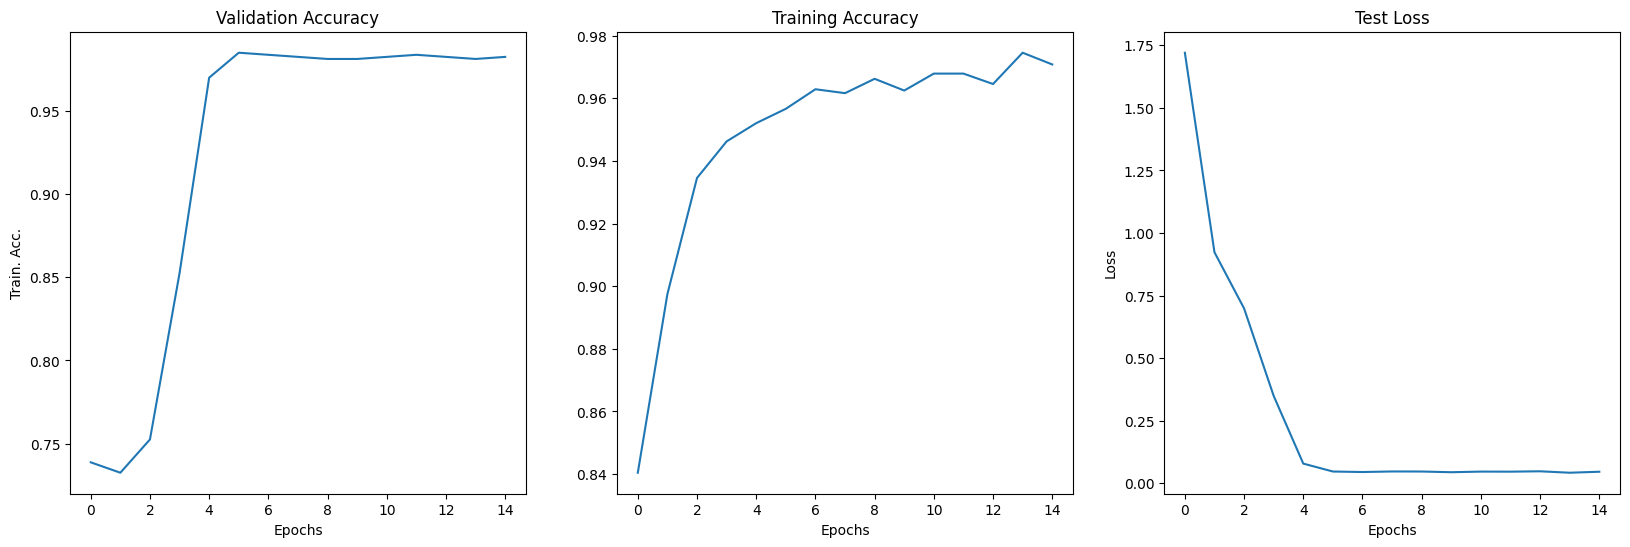

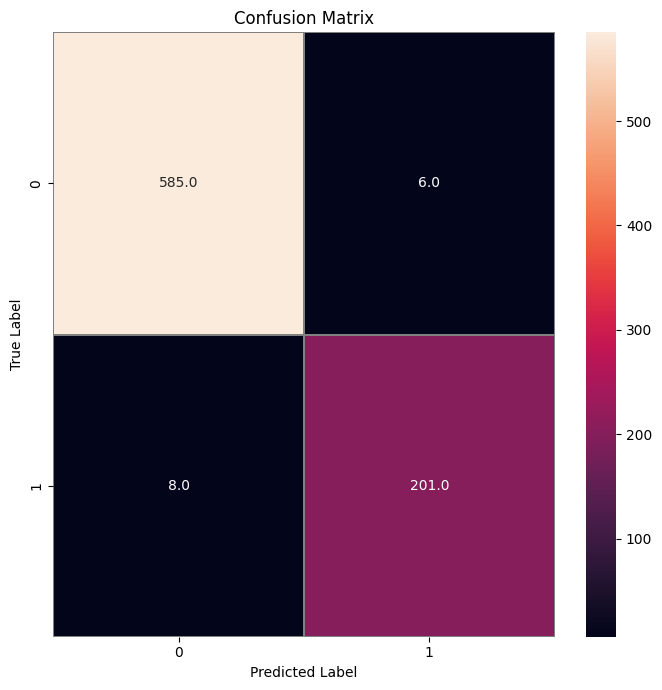

In [ ]:
from sklearn import metrics
import seaborn as sns
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)
# Compute the confusion matrix

print("\n""Test Accuracy Score : ",metrics.accuracy_score(Y_true, Y_pred_classes),"\n")

fig, axis = plt.subplots(1, 3, figsize=(20,6))
axis[0].plot(history.history['val_accuracy'], label='val_acc')
axis[0].set_title("Validation Accuracy")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Val. Acc.")
axis[1].plot(history.history['accuracy'], label='acc')
axis[1].set_title("Training Accuracy")
axis[1].set_xlabel("Epochs")
axis[0].set_ylabel("Train. Acc.")
axis[2].plot(history.history['val_loss'], label='val_loss')
axis[2].set_title("Test Loss")
axis[2].set_xlabel("Epochs")
axis[2].set_ylabel("Loss")

plt.show()


confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# Plot the confusion matrix
f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()

plt.show()

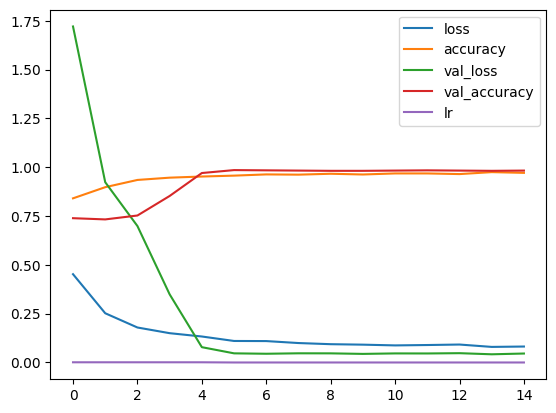

In [ ]:
pd.DataFrame(history.history).plot();

In [ ]:
prediction = model.predict(x_test)
pd.Series(prediction[0], index=["Not A Ship", "Ship"])

25/25 [==============================] - 3s 100ms/step


Not A Ship    0.006644
Ship          0.993356
dtype: float32

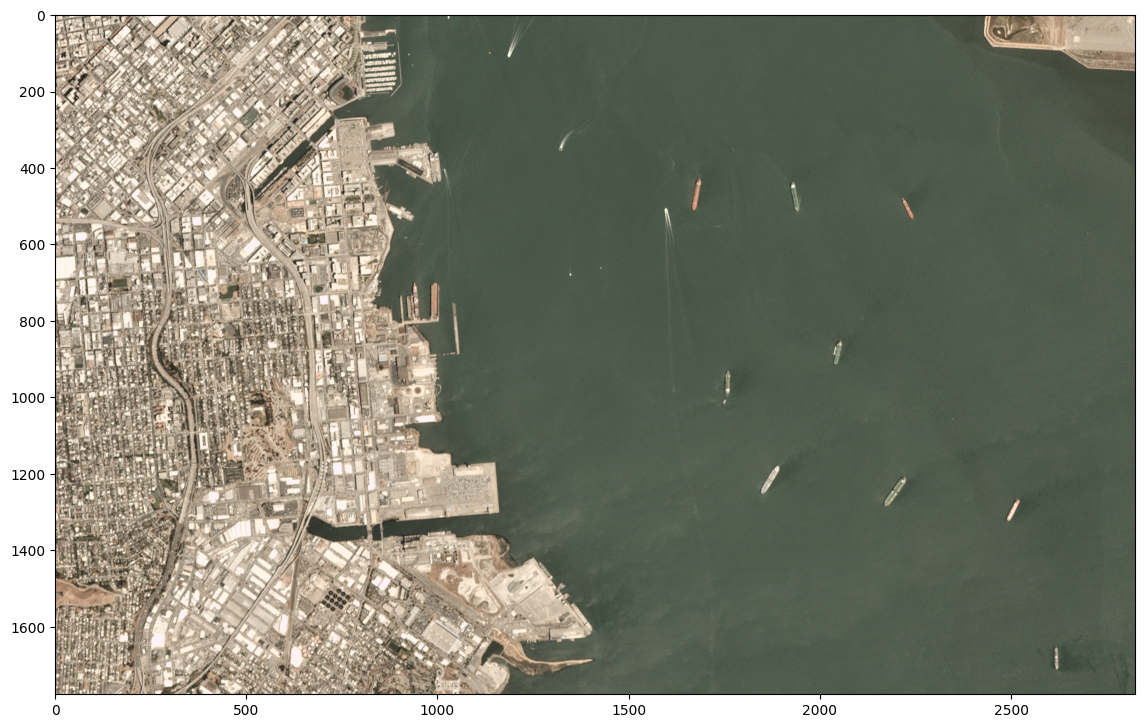

In [ ]:

image = Image.open('/kaggle/input/ships-in-satellite-imagery/scenes/scenes/sfbay_1.png')
pix = image.load()
n_spectrum = 3
width = image.size[0]
height = image.size[1]
# creat vector
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(pix[x, y][chanel])
picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width]).transpose(1, 2, 0)
plt.figure(1, figsize = (15, 30))

plt.subplot(3, 1, 1)
plt.imshow(picture_tensor)

plt.show()

1/1 [==============================] - 0s 36ms/step
[[0.01228613 0.9877138 ]]


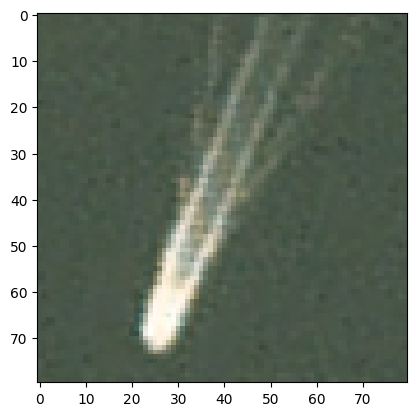

1/1 [==============================] - 0s 32ms/step
[[0.01391709 0.98608285]]


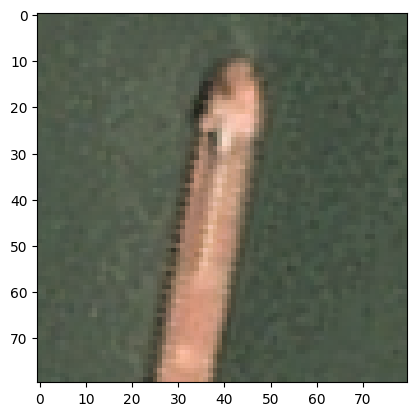

1/1 [==============================] - 0s 32ms/step
[[0.04655326 0.9534468 ]]


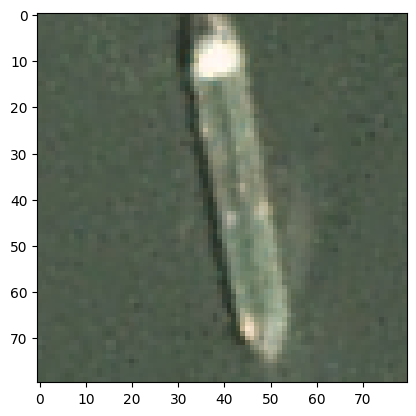

1/1 [==============================] - 0s 31ms/step
[[0.08305328 0.9169467 ]]


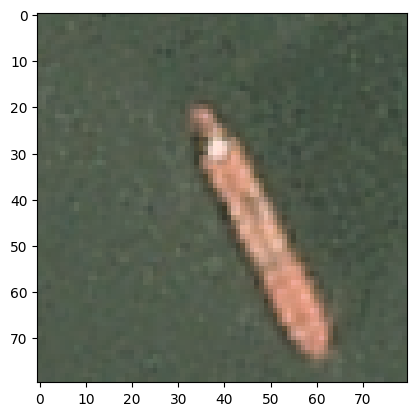

1/1 [==============================] - 0s 41ms/step
[[0.09816521 0.9018347 ]]


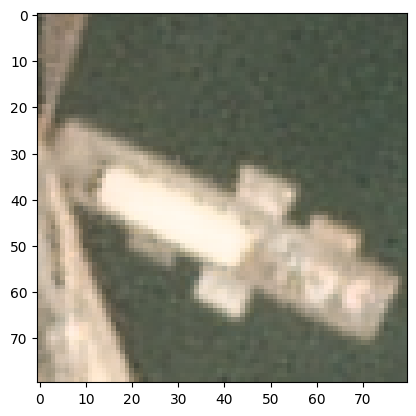

1/1 [==============================] - 0s 37ms/step
[[0.04771398 0.95228606]]


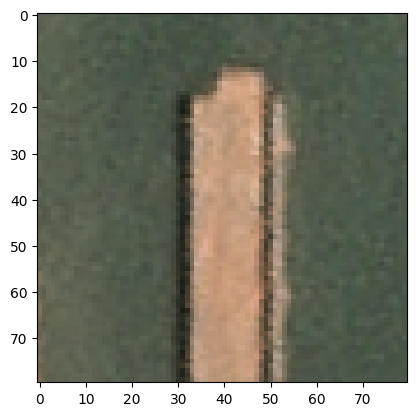

1/1 [==============================] - 0s 43ms/step
[[0.08743338 0.9125666 ]]


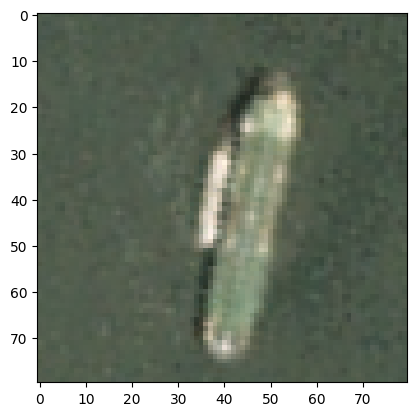

1/1 [==============================] - 0s 33ms/step
[[0.09188481 0.9081152 ]]


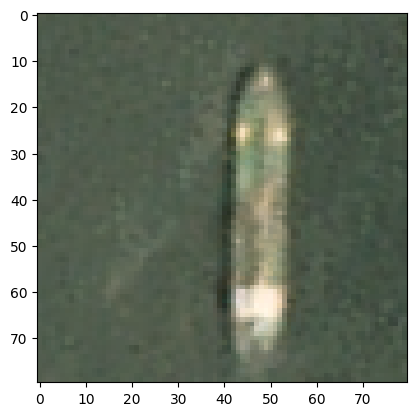

1/1 [==============================] - 0s 50ms/step
[[0.01600453 0.9839955 ]]


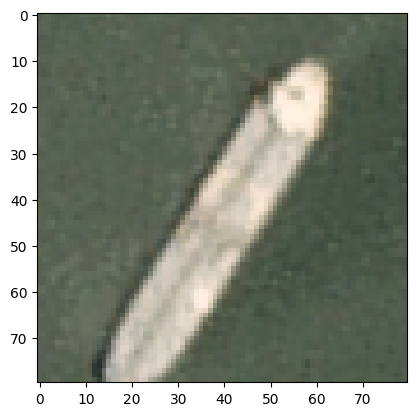

1/1 [==============================] - 0s 39ms/step
[[0.05387867 0.94612134]]


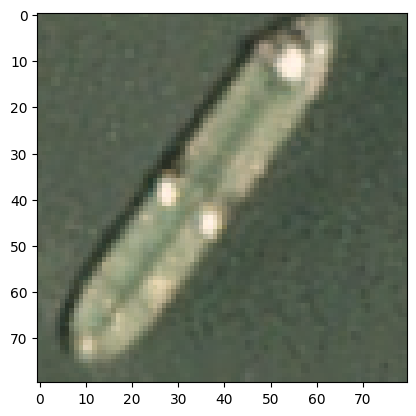

1/1 [==============================] - 0s 34ms/step
[[0.03059254 0.9694074 ]]


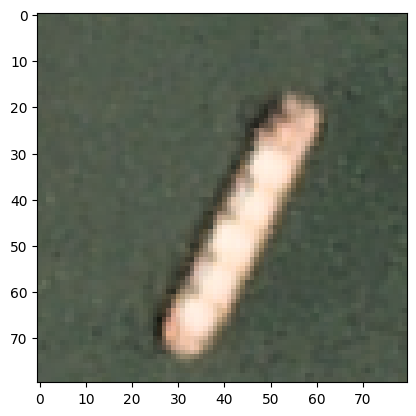

1/1 [==============================] - 0s 31ms/step
[[0.0429594  0.95704055]]


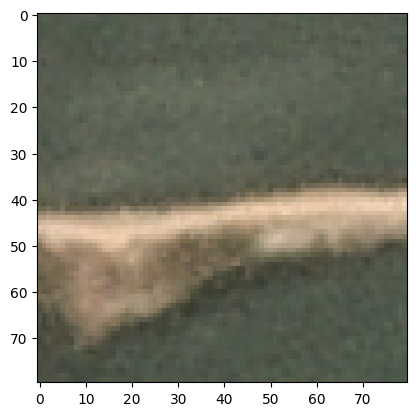

1/1 [==============================] - 0s 73ms/step


In [ ]:
picture_tensor = picture_tensor.transpose(2,0,1)

def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picture_tensor[0][y+i][x+j]
            area_study[1][i][j] = picture_tensor[1][y+i][x+j]
            area_study[2][i][j] = picture_tensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    sys.stdout.write('\rX:{0} Y:{1}  '.format(x, y))
    return area_study
def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result
def show_ship(x, y, acc, thickness=5):
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x+th+80] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y-th][x+i] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+th+80][x+i] = -1
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.90 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
            print(result)
            plt.imshow(area[0])
            plt.show()

In [ ]:
for e in coordinates:
    show_ship(e[0][0], e[0][1], e[1][0][1])
#picture_tensor = picture_tensor.transpose(2,0,1)
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape

(1777, 2825, 3)

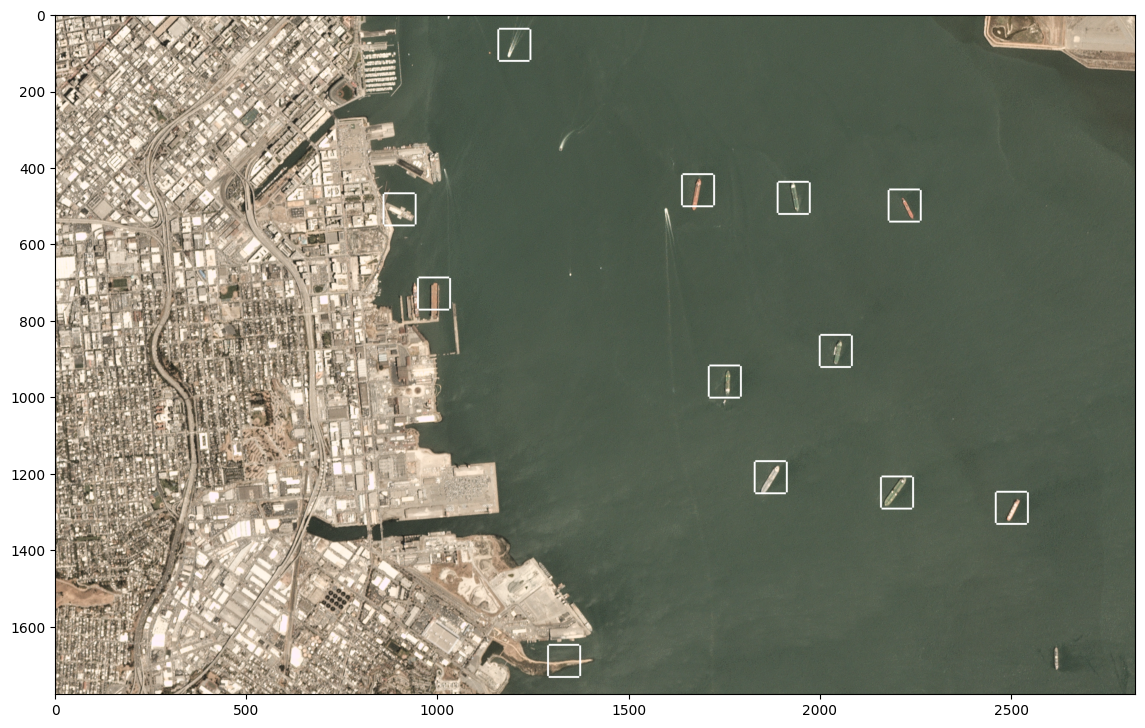

In [ ]:
plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()